In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!pip install openpyxl -qq
!pip install tenacity -qq
!pip install loguru -qq
!pip install git+https://git@github.com/NASA-IMPACT/evalem.git@develop -qq
!pip install rake-nltk -qq

In [2]:
import json
from typing import List

In [3]:
from pprint import pprint
from IPython.display import display, HTML

In [4]:
from loguru import logger
import glob
import random
import re

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load Validation Data

In [6]:
FILE_PATH = "data/OSDR_LLM_QA_correctFormat.xlsx"

In [7]:
def load_data(path) -> pd.DataFrame:
    data = pd.read_excel(path)
    data = data.rename(columns={data.columns[0]: 'context'})
    return data

In [8]:
def simplify_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    transformed_data = []
    for index, row in df.iterrows():
        context = row['context']
        url = row['URL']
        for i in range(1, 6): # Assuming there are 5 question-answer pairs
            question = row[f'Question {i}']
            answer = row[f'Question {i} Answer']
            if question and answer:
                transformed_data.append(dict(
                    context=context,
                    context_hash=abs(hash(context)) % (10 ** 8),
                    url=url,
                    question=question,
                    answer=answer,
                ))
    df =  pd.DataFrame(transformed_data)
    return df.dropna(subset=['question', 'answer'], how='all')

In [9]:
data = load_data(FILE_PATH)
data.head()

,context,URL,Question 1,Question 1 Answer,Question 2,Question 2 Answer,Question 3,Question 3 Answer,Question 4,Question 4 Answer,Question 5,Question 5 Answer
0,Genome-wide transcriptional profiling showed t...,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
1,The objective of the Rodent Research-5 (RR-5) ...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...,How many days after launch were the mice treat...,Six days after launch,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen...",What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...
2,The radiation bystander response is an importa...,https://sciencediscoveryengine.nasa.gov#/previ...,What is a key component of the overall respons...,The radiation bystander response,Which methods were used to measure the bystand...,using chromosomal aberration and micronucleus ...,What was shown to increase chromosomal structu...,depletion or mutation of RAD9,what cellular pathways were altered as a resul...,The depletion of RAD9 caused changes in numero...,How were differences in the activation of tran...,The use of network analysis allowed the discov...
3,Martian regolith (unconsolidated surface mater...,https://sciencediscoveryengine.nasa.gov#/previ...,What is considered a potential medium for plan...,Martian regolith (unconsolidated surface mater...,What is the level of hydrated magnesium sulfat...,hydrated magnesium sulfate mineral levels in t...,What was characterized in the study to identif...,The early Arabidopsis root transcriptome respo...,how was the genetic comparison approached to d...,A comparative analysis was conducted between t...,What distinctive characteristic does the cax1-...,The cax1-1 mutant line demonstrated relative t...
4,The objective of the Rodent Research-23 missio...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the objective of the Rodent Research-...,to better understand the effects of spacefligh...,How many mice and of what type were involved i...,"twenty male, C57BL/6J, 16-17 weeks-old mice",How long were the mice in the RR-23 study main...,maintained in microgravity for 38 days,What was the procedure followed for the mice f...,"The mice, after landing in the Atlantic, were ...",How was RNA extraction and analysis managed fo...,Adrenal glands of the mice were preserved by i...


## Data Peek

Here we pick a sample row to inspect the nature of data.
- What each column looks like

In [10]:
def peek_data(data: pd.DataFrame, row_index: int = 0):
    print(f"Row = {row_index}")
    row = data.iloc[row_index]
    for col, value in zip(data.columns, row):
        display(HTML(f"<h4>{col}</h4>"))
        print(value)
        display(HTML("<hr/>"))

In [11]:
data.shape

(60, 12)

In [12]:
# index = random.randint(0, len(data))
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


What is overrepresented in the different experiments despite particular genes not being common?


the same GO groups including a large multigene family related with behavior, stress response and organogenesis


what analytical methodology provided integrative insights on transcriptome variations?


Self-organizing maps of the Gene Expression Dynamics Inspector (GEDI) were utilized to reveal transcriptome variations under various environmental conditions or microgravity/hypergravity simulation devices.


What are the implications of the findings in terms of the tuning of the transcriptome to Earth's gravity and its variations in extreme environmental conditions?


The findings indicate that the finely adjusted transcriptome is tuned to normal Earth gravity, showing a more marked and coherent genetic response when environmental conditions significantly deviate from optimal.


## Simplify Data

Here we separate out individual question/answer pair into separate row for each context.


This is used for simplifying the validation process so that each row would have consistent view of data.

In [13]:
data = simplify_columns(data)
data.head(10)

,context,context_hash,url,question,answer
0,Genome-wide transcriptional profiling showed t...,82796915,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...
1,Genome-wide transcriptional profiling showed t...,82796915,https://sciencediscoveryengine.nasa.gov#/previ...,What kind of experiments showed differential r...,simulation experiments on ground testing space...
2,Genome-wide transcriptional profiling showed t...,82796915,https://sciencediscoveryengine.nasa.gov#/previ...,What is overrepresented in the different exper...,the same GO groups including a large multigene...
3,Genome-wide transcriptional profiling showed t...,82796915,https://sciencediscoveryengine.nasa.gov#/previ...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...
4,Genome-wide transcriptional profiling showed t...,82796915,https://sciencediscoveryengine.nasa.gov#/previ...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
5,The objective of the Rodent Research-5 (RR-5) ...,74429782,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...
6,The objective of the Rodent Research-5 (RR-5) ...,74429782,https://sciencediscoveryengine.nasa.gov#/previ...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...
7,The objective of the Rodent Research-5 (RR-5) ...,74429782,https://sciencediscoveryengine.nasa.gov#/previ...,How many days after launch were the mice treat...,Six days after launch
8,The objective of the Rodent Research-5 (RR-5) ...,74429782,https://sciencediscoveryengine.nasa.gov#/previ...,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen..."
9,The objective of the Rodent Research-5 (RR-5) ...,74429782,https://sciencediscoveryengine.nasa.gov#/previ...,What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...


In [14]:
data.shape

(295, 5)

In [15]:
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

82796915


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


In [16]:
peek_data(data, row_index=1)

Row = 1


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

82796915


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


# promptlab 


**promptlab** provides a programmatic approach to interact with the bot via its REST API.
Specificially, the `/process/` endpoint can process any query and generate the respond accordingly.
https://api.promptlab.nasa-impact.net/api/v1/process/

We can send a request to the API with the query/question and get the response.

Here, the `FlowRunner` class abstracts everything. Its `.run(...)` method processes the query which:
- Takes in a query string
- Returns a result json/dictionary

The result from the API tentatively gives us following information:

- *question* : input question fed into the bot
- *answer* : generated answer based on retrieved contexts
- *retrieved contexts* : List of **top-k** contexts retrieved by the RAG system

## setup flow processors

In [17]:
import requests
from typing import Optional, Union
import urllib.parse

In [18]:
from loguru import logger

In [19]:
from tenacity import retry, retry_if_result, stop_after_attempt, wait_fixed, retry_if_exception, retry_if_exception_type

In [20]:
# Setup the base URL to point to the production
BASE_API_URL = "https://api.promptlab.nasa-impact.net/api/v1/process/"

# Setup api key to authenticate
PROMPTLAB_API_KEY =  "sk-e0bvhSxSSk5Vw16d-8s1cVGjUcr9d7nam49-6K28FZQ"

In [21]:
# tweaks for the OSDR bot flow
TWEAKS = {
  "ConversationalRetrievalChain-83vns": {},
  "ChatOpenAI-gsfUD": {"model": "gpt-3.5-turbo"},
  "ConversationBufferMemory-z2ZqE": {},
  "Sinequa-Z8S73": {}
}

# flow id of the OSDR bot in promptlab that is used for QA programmatically
FLOW_ID = "1edbe0f9-d7ff-4c2a-a371-5f6312964f05"

In [22]:
class FlowRunner:
    def __init__(self, base_url: str, api_key: str, debug:bool = False) -> None:
        self.base_url = base_url
        self.api_key = api_key
        self.debug=bool(debug)

    def run_flow(
        self,
        inputs: dict,
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        """
        Run a flow with a given message and optional tweaks.
    
        :param message: The message to send to the flow
        :param flow_id: The ID of the flow to run
        :param tweaks: Optional tweaks to customize the flow
        :return: The JSON response from the flow
        """
        api_url = urllib.parse.urljoin(self.base_url, flow_id)
        if self.debug:
            logger.debug(f"URL = {api_url}")

        api_key = self.api_key
        payload = {"inputs": inputs}
        headers = None
        if tweaks:
            payload["tweaks"] = tweaks
        if api_key:
            headers = {"x-api-key": api_key}
        response = requests.post(api_url, json=payload, headers=headers)
        if self.debug:
            logger.debug(f"response = {response}")
            logger.debug(f"status code = {response.status_code}")
        if response.status_code != 200:
            raise requests.exceptions.HTTPError(f"Error: {response.status_code}")
        return response.json()

    @staticmethod
    def if_not_valid_result(result: dict) -> bool:
        return not (isinstance(result, dict) and "result" in result and "answer" in result.get("result", {}))
    
    @retry(
        retry=(retry_if_exception_type(requests.exceptions.RequestException) | retry_if_result(if_not_valid_result)),
        stop=stop_after_attempt(3),
        wait=wait_fixed(2)
    )
    def run(
        self,
        input: Union[dict, str],
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        if isinstance(input, str):
            input = dict(question=input)
        result = self.run_flow(
            inputs=input,
            flow_id=flow_id,
            tweaks=tweaks,
        )
        result["question"] = input["question"] if isinstance(input, dict) else input

        if "result" in result:
            source_documents = result.get("result", {}).get("source_documents", "[]")
            if isinstance(source_documents, str):
                result["result"]["source_documents"] = json.loads(source_documents)
        return result

    @staticmethod
    def display_result(result: dict, question: Optional[str]=None, reference_answer=None):
        header_tag = "h4"
        question = result.get("question", question)
        if question:
            display(HTML(f"<{header_tag}>Question</{header_tag}>"))
            print(question)
            display(HTML("<hr/>"))

        if "result" in result:
            result = result["result"]
        display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
        print(result["answer"])
        display(HTML("<hr/>"))

        if reference_answer:
            display(HTML(f"<{header_tag}>Exepcted Answer (Reference/Ground Truth)</{header_tag}>"))
            print(reference_answer)
            display(HTML("<hr/>"))
        
        # display(HTML(f"<{header_tag}>Retrieved Contexts</{header_tag}>"))
        for idx, doc in enumerate(result["source_documents"], start=1):
            display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
            print(doc["page_content"])
            print(doc["metadata"]["source"])
            display(HTML("<hr/>"))

## Test Run

Now, let's check what a sample test run looks like when we call the API for QA.

In [23]:
flow_runner = FlowRunner(
    base_url=BASE_API_URL,
    api_key=PROMPTLAB_API_KEY
)

In [24]:
query = "What parasites were sent to ISS to study host immunity?"

In [25]:
result = flow_runner.run(
    input=query,
    flow_id=FLOW_ID,
    tweaks=TWEAKS,
)

In [26]:
result["question"]

'What parasites were sent to ISS to study host immunity?'

In [27]:
flow_runner.display_result(result)

What parasites were sent to ISS to study host immunity?


In the study mentioned, fruit flies and their parasitic wasps were sent to the ISS to examine changes in host immunity and parasite virulence. The parasitic wasps included Leptopilina boulardi 17 and Leptopilina heterotoma 14.


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Drosophila melanogaster data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina boulardi 17 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina heterotoma14 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  1.26 TB  OSD-588 Version 1  Drosophila parasitoids go to space: Unexpected effects of spaceflight on <b>hosts</b> and their parasitoids - Drosophila data <b>Study</b>  Submitted Date: 02-Feb-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-583 DOI : 10.26030/v9rh-5a70  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  148.92 GB  OSD-610 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina boulardi 17 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-587 DOI : 10.26030/9ee4-6s36  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  176.26 GB  OSD-609 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina heterotoma 14 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-586 DOI : 10.26030/5rjq-a347  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


The biology chosen for this experiment was Arabidopsis thaliana, ecotype Col-0, because of the plant's history of spaceflight experimentation within KFTs and wealth of comparative data from orbital experiments. KFTs were deployed as a wearable device, a leg pouch attached to the astronaut, which proved to be operationally effective during the course of the flight. Data from the inflight samples indicated that the microgravity period of the flight elicited the strongest transcriptomic responses as measured by the number of genes showing differential expression.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-624/


Fungal Pathogenesis , Tumorigenesis , and Effects of <b>Host</b> <b>Immunity</b> in Space  Project Type  Spaceflight <b>Study</b>  Flight Program  Space Transportation System (STS)  Experiment Platform  Shuttle Life Sciences Research (Middeck)  Sponsoring Agency  NASA  NASA Center  Ames Research Center (ARC)  Funding Source  This <b>study</b> work was supported by a NASA grant to SB for Fungal Pathogenesis, Tumorigenesis, and Effects of <b>Host</b> <b>Immunity</b> in the Space Environment (FSB-FIT-2005). The funder had a role in <b>study</b> design and in supporting data collection.  Acknowledgments  We thank David Schneider for helping us with the design of this experiment.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-3/


Spaceflight uniquely alters the physiology of both human cells and microbial pathogens, stimulating cellular and molecular changes directly relevant to infectious disease. However, the influence of this environment on host-pathogen interactions remains poorly understood. Here we report our results from the STL-IMMUNE study flown aboard Space Shuttle mission STS-131, which investigated multi-omic responses (transcriptomic, proteomic) of human intestinal epithelial cells to infection with Salmonella Typhimurium when both host and pathogen were simultaneously exposed to spaceflight. To our knowledge, this was the first in-flight infection and dual RNA-seq analysis using human cells.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-323/


Immune dysregulation is among the main adverse outcomes of spaceflight. Despite its crucial role in host protection, effects on the human antibody repertoire are unknown. Consequently, we examined the IgM repertoire of five cosmonauts 25 days before launch, after 64 and 129 days spent on the International Space Station (ISS), and after 1, 7 and 30 days of Earth reambulation using high-throughput sequencing. This is the first study of this kind.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-316/


# Run OSDR Validation set

Instead of manually running each question through the bot to generate the answer, we run all the questions from the validation data in bulk.

We have some functions for housekeeping and the details for them are hidden away for brevity.

> Note: Since it takes some time to run through all the questions, we'll pre-load the responses from a csv.

In [28]:
from tqdm import tqdm
from joblib import Parallel, delayed
import ast

In [29]:
def process_row(row, flow_runner, flow_id, tweaks):
    try:
        result = flow_runner.run(input=row.question, flow_id=flow_id, tweaks=tweaks)
    except:
        logger.error(f"Error for question={row.question}. Skipping")
        result = {}
    print(result.keys())
    result["reference_context"] = row.context
    result["reference_answer"] = row.answer
    result["context_hash"] = row.context_hash
    return result

In [30]:
def get_osdr_responses(
    data: pd.DataFrame,
    flow_runner: FlowRunner,
    flow_id,
    tweaks
) -> pd.DataFrame:
    results = []
    for row in tqdm(data.itertuples()):
        result = process_row(row, flow_runner, flow_id, tweaks)
        results.append(result)
    return pd.DataFrame(results)

def get_osdr_responses_parallel(
    data: pd.DataFrame,
    flow_runner,
    flow_id, 
    tweaks
) -> pd.DataFrame:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)\
        (row, flow_runner, flow_id, tweaks) for row in tqdm(data.itertuples(index=False))
    )
    results_df = pd.DataFrame(results)
    return results_df

In [31]:
def load_responses(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["result"] = df["result"].apply(ast.literal_eval)
    return df

In [ ]:
# # get all the responses
responses = get_osdr_responses_parallel(
    data=simplify_columns(load_data(FILE_PATH)).iloc[:],
    flow_runner=flow_runner,
    flow_id=FLOW_ID,
    tweaks=TWEAKS
)

In [32]:
# load already dumped responses
responses = load_responses("data/responses-gpt-3.5-turbo.csv")

In [ ]:
responses.head(3)

In [ ]:
responses.to_csv("data/responses-gpt-3.5-turbo.csv", index=False)

In [33]:
sample_row = responses.sample(1)
FlowRunner.display_result(
    sample_row.result.iloc[0],
    sample_row.question.iloc[0],
    reference_answer=sample_row.reference_answer.iloc[0]
)

Who was the principal investigator for this study?


The principal investigators for the mentioned studies are Kasthuri J Venkateswaran, Sally A Amundson, Rosamund Smith, Jamie Foster, and Amrita K. Cheema.


Rob Ferl was the principal investigator for this study.


We would like to thank all the astronauts who participated in this <b>study</b> and provided saliva.  Contact(s)  Kasthuri J Venkateswaran email , Credit: <b>principal</b> <b>investigator</b> Affiliation: NASA Jet Propulsion Laboratory Email: kjvenkat@jpl.nasa.gov Camilla Urbaniak , Credit: Affiliation: NASA Jet Propulsion Laboratory Hernan Lorenzi , Credit: Affiliation: NASA Johnson Space Center James Thissen , Credit: Affiliation: Lawrence Livermore National Laboratory Crystal Jaing , Credit: Affiliation: Lawrence Livermore National Laboratory Brian Crucian , Credit: Affiliation: NASA Johnson Space Center Clarence Sams , Credit: Affiliation: NASA Johnson Space Center Duane Pierson , Credit: Affiliation: NASA Johnson Space Center Satish Mehta Credit: Affiliation: NASA Johnson Space Center  assignment Experiments
https://osdr.nasa.gov/bio/repo/data/studies/OSD-280/


This <b>study</b> was supported by the Biomedical Advanced Research and Development Authority (BARDA), Office of the Assistant Secretary for Preparedness and Response, Office of the Secretary, Department of Health and Human Services under Contract No. HHS01201000008C. SAA was also supported by the Center for High-Throughput Minimally-Invasive Radiation Biodosimetry, National Institute of Allergy and Infectious Diseases Grant Number U19 AI067773  Contact(s)  Sally A Amundson email , Credit: <b>principal</b> <b>investigator</b> Affiliation: Columbia University Email: saa2108@cumc.columbia.edu Sunirmal Paul , Credit: Author Affiliation: Norman J Kleiman Credit: Author Affiliation:  assignment Experiments  No associated experiments  explore Payloads  No associated payloads  rocket_launch Missions
https://osdr.nasa.gov/bio/repo/data/studies/OSD-455/


Samples from the RR-3 experiment were provided to GeneLab through the Biospecimen Sharing Plan of the NASA Life Sciences Data Archive. We would like to acknowledge the NASA Biospecimen Sharing Program (BSP) for their expertise and efforts in coordinating and collecting all the samples in this <b>study</b>.  Contact(s)  Rosamund Smith , Credit: <b>Principal</b> <b>Investigator</b> Affiliation: Eli Lilly and Company Marty Cramer , Credit: Co-<b>Investigator</b> Affiliation: Eli Lilly and Company Ruth Globus email , Credit: Project Scientist Affiliation: NASA Ames Research Center Email: ruth.k.globus@nasa.gov Jonathan Galazka email Credit: Project Scientist Affiliation: NASA GeneLab Email: jonathan.m.galazka@nasa.gov  assignment Experiments  No associated experiments  explore Payloads  Identifier  Name  Type  Description
https://osdr.nasa.gov/bio/repo/data/studies/OSD-137/


Ames Research Center (ARC)  Funding Source  This <b>study</b> was supported by NASA's Space Biology program grant NNX13AM44G.  Additional Project Metadata  LSDA Archived Data Link  Contact(s)  Jamie Foster , Credit: <b>Principal</b> <b>Investigator</b> Affiliation: University of Florida Giorgio Casaburi email Credit: Post Doctoral Research Associate Affiliation: University of Florida Email: giorgiocasaburi@gmail.com  assignment Experiments  No associated experiments  explore Payloads  No associated payloads  rocket_launch Missions  No associated missions  content_paste Protocols  visibility Expand All visibility_off Collapse All  Samples  Assay - transcription profiling - nucleotide sequencing - Illumina  science Samples  Select Export Columns  Source Name  Sample Name  Comment: Source Name Description  Characteristics: Organism  Characteristics: secondary organism  Characteristics: age
https://osdr.nasa.gov/bio/repo/data/studies/OSD-119/


We would like to acknowledge the NASA Biospecimen Sharing Program (BSP) for their expertise and efforts in coordinating and collecting all the samples in this <b>study</b>.  Contact(s)  Rosamund Smith , Credit: <b>Principal</b> <b>Investigator</b> Affiliation: Eli Lilly and Company Marty Cramer , Credit: Co-<b>Investigator</b> Affiliation: Eli Lilly and Company Ruth Globus email , Credit: Project Scientist Affiliation: NASA Ames Research Center Email: ruth.k.globus@nasa.gov Jonathan Galazka email Credit: Project Scientist Affiliation: NASA GeneLab Email: jonathan.m.galazka@nasa.gov  assignment Experiments  No associated experiments  explore Payloads  No associated payloads  rocket_launch Missions  Identifier  Start Date  End Date  SpaceX-8  08-Apr-2016  11-May-2016  SpaceX-9  18-Jul-2016  26-Aug-2016
https://osdr.nasa.gov/bio/repo/data/studies/OSD-162/


mCT imaging was performed at the Bone Imaging Research Core of the Endocrine Research Unit at the UCSF-affiliated Veterans Affairs Medical Center. We would also like to thank Aaron Fields and Jeannie Bailey for contributing helpful advice for this <b>study</b>. None of the authors have affiliations that are perceived to have biased the presentation.  Contact(s)  Jeffrey C. Lotz email , Credit: <b>principal</b> <b>investigator</b> Affiliation: UC San Francisco Email: jeffrey.lotz@ucsf.edu Britta Berg-Johansen , Credit: Research Personnel Affiliation: UC San Francisco Ellen C. Liebenberg , Credit: Research Personnel Affiliation: UC San Francisco Alfred Li , Credit: Research Personnel Affiliation: UC San Francisco Brandon R. Macias , Credit:
https://osdr.nasa.gov/bio/repo/data/studies/OSD-471/


Funding for this <b>study</b> was supported by NASA grants NNX13AM01G (C.A.N., J.B., C.M.O., B.J.A.), NNX15AL06G (C.A.N., J.B., C.M.O.) and 80NSSC18K1478 (C.A.N., J.B., C.M.O. and H.B.).  Additional Project Metadata  LSDA Archived Data Link  Contact(s)  Kristina Buss email , Credit: formal analysis role Affiliation: Bioinformatics Core Facility, Bioscience, Knowledge Enterprise, Arizona State University Email: kristina.buss@asu.edu Jennifer Barrila email , Credit: Co-<b>principal</b> <b>investigator</b> Affiliation: The Biodesign Institute, Arizona State University Email: Jennifer.Barrila@asu.edu Cheryl A Nickerson email , Credit: Co-<b>principal</b> <b>investigator</b> Affiliation: The Biodesign Institute, Arizona State University Email: Cheryl.Nickerson@asu.edu Karla Franco , Credit: Affiliation: Shanshan Yang , Credit: Affiliation: Trenton Davis , Credit: Affiliation:
https://osdr.nasa.gov/bio/repo/data/studies/OSD-277/


Organism(s)  Microbiota  Assay(s)  Measurement  Technology  Device Platform  metagenome profiling  nucleotide sequencing  Illumina  Project  Project Type  Ground <b>Study</b>  Funding Source  This <b>study</b> was supported by the National Space Biomedical Research Institute [RE03701 through NCC 9-58] and the NIH National Center for Advancing Translational Science (NCATS) UCLA CTSI Grant Number UL1TR00188.  Contact(s)  Amrita K. Cheema email , Credit: <b>principal</b> <b>investigator</b> Affiliation: Georgetown University Medical Center Email: akc27@georgetown.edu David Casero Credit: submitter Affiliation: Department of Pathology and Laboratory Medicine, David Geffen School of Medicine, University of California, Los Angeles  assignment Experiments  No associated experiments  explore Payloads  No associated payloads  rocket_launch Missions
https://osdr.nasa.gov/bio/repo/data/studies/OSD-146/


# Evaluation

Here, we evaluate the generated responses. We primarily follow two modes of evaluation:

- I. Evaluation of **retrieved contexts** (recall)

    How good/accurate are the retrieved contexts based on the input query?

- II. Evaluation of **generated answers** (different evaluation metrics)

    How good/accurate are the generated answers?

In [34]:
from evalem.nlp.metrics import (
    BertScore,
    ExactMatchMetric,
    MeteorMetric,
    RougeMetric,
)
from evalem import Evaluator
from evalem._base.structures import MetricResult

In [35]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from rake_nltk import Rake

In [36]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/npantha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieval Evaluation

In this mode of evaluation, we compare whether the actual context (which is the ground truth context) lies in any of the **top-k** retrieved context chunks.

$$\text{Recall} = \begin{cases} 
1 & \text{if actual context is in top } k \text{ retrieved contexts}, \\
0 & \text{otherwise}.
\end{cases}$$

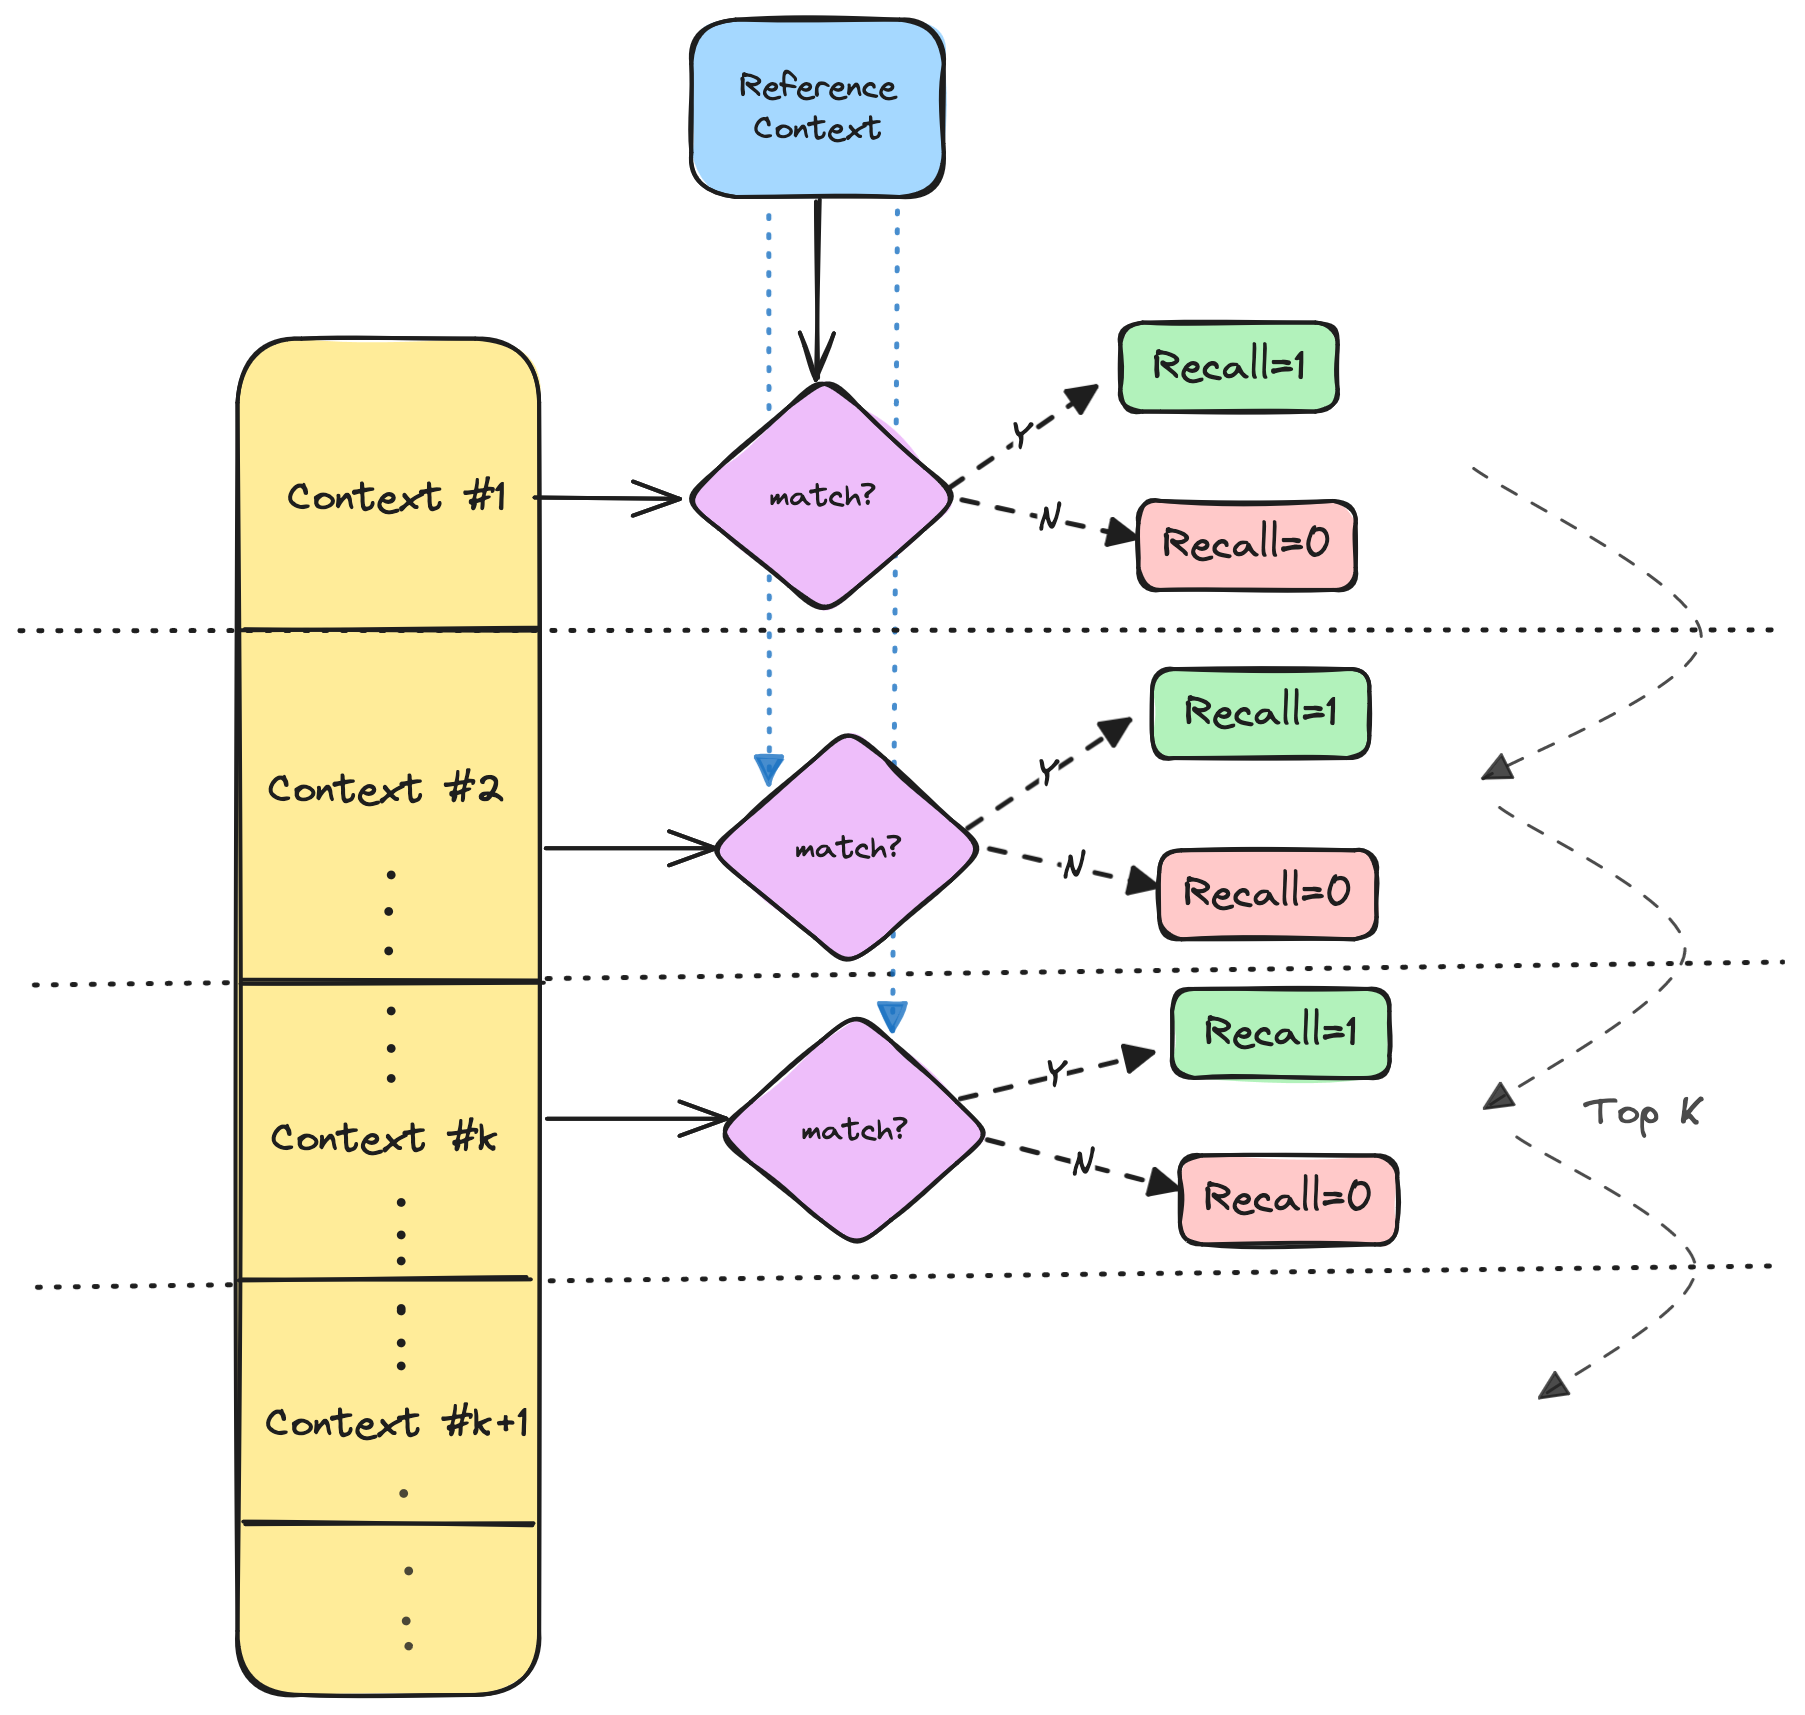

### Keyword-based evaluation

We compute the recall of retrieved contexts based on the overlapping of keywords between the
actual context (ground truth context) and the retrieved context.

In [37]:
def extract_keywords(text, top_k: int = 10):
    text = preprocess_text(text, top_k)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return set(keywords)

def preprocess_text(text, top_k=10):
    text = text.lower()
    r = Rake()
    r.extract_keywords_from_text(text)
    return " ".join(set(r.get_ranked_phrases()[:top_k]))

def compute_recall_kws(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    ref_keywords = extract_keywords(reference, top_k_kws)
    relevant_items = 0

    recall = 0.0

    if debug:
        print(f">>>>> reference = {reference}")
        print(f">>>>> reference keywords = {ref_keywords} | {len(ref_keywords)}")
    for idx, value in enumerate(retrieved_values, start=1):
        keywords = extract_keywords(value, top_k=top_k_kws)
        overlap = len(ref_keywords.intersection(keywords))
        score = overlap/len(ref_keywords)
        if debug:
            print(f">>>>> retrieved = {value}")
            print(f">>>>> retrieved kws = {keywords}")
            print(f">>>>> overlap = {overlap}")
            print(f">>>> score = {score}")

        if score >= threshold:
            recall = 1.0
        if idx >= top_k:
            break
    return recall

def evaluate_contexts_keywords(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall = compute_recall_kws(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall
        ))
    return pd.DataFrame(results)

In [38]:
def batch_evaluate_contexts_keywords(
    response: pd.DataFrame,
):
    final_df = []
    for threshold in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        for top_k in range(1, 10):
            for top_k_kws in [25, 50]:
                result = evaluate_contexts_keywords(
                    response,
                    threshold=threshold,
                    top_k=top_k,
                    top_k_kws=top_k_kws,
                    debug=False
                )
                fname = f"data/evals/retrieval/keywords/eval-context-keywords-{threshold}-{top_k}-{top_k_kws}.csv"
                logger.debug(f"Dumping eval to {fname}")
                result.to_csv(fname, index=False)

def load_retrieval_eval_keywords(
    directory: str,
    pattern: Optional[str] = None
) -> pd.DataFrame:
    
    if pattern is None:
        pattern = "eval-context-keywords-([0-9.]+)-([0-9]+)-([0-9.]+).csv"
    
    dfs = []
    search_path = f"{directory}/eval-context-keywords*.csv"
    for path in glob.glob(search_path):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
            df["top_k_kws"] = int(match.group(3))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

In [39]:
def peek_evaluation_result(df: pd.DataFrame, peek_type:str ="max"):
    df = df.copy()
    peek_type = peek_type.lower().strip()
    if peek_type in ["max", "good"]:
        df = df[df['recall'] == df['recall'].max()]
    else:
        df = df[df['recall'] == df['recall'].min()]
        
    row = df.sample(n=1).iloc[0]

    header_tag = "h4"
    display(HTML(f"<h3>{'Good' if peek_type in ['max', 'good'] else 'Bad'} Recall (Passage Overlap Threshold={row['threshold']}, top_k={row['top_k']})</h3"))
    display(HTML(f"<{header_tag}>Question</{header_tag}>"))
    print(row["question"])

    display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
    print(row["prediction"])

    display(HTML(f"<{header_tag}>Actual Answer</{header_tag}>"))
    print(row["answer"])

    display(HTML(f"<{header_tag}>Actual Context</{header_tag}>"))
    print(row["context"])

    display(HTML("<hr/>"))
    for idx, ctx in enumerate(row["retrieved_contexts"], start=1):
        display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
        print(ctx)

In [40]:
def plot_mean_recall_kws(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')
    df['top_k_kws'] = pd.to_numeric(df['top_k_kws'], errors='coerce')

    # df = df.groupby(['threshold', 'top_k', 'top_k_kws'])['recall'].mean().reset_index()

    # df_mean_recall = df.copy()

    # mean recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='hls')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

In [41]:
eval_retrieval_kws = load_retrieval_eval_keywords(directory="data/evals/retrieval/keywords/")
print(eval_retrieval_kws.shape)
eval_retrieval_kws.head()

(30996, 9)


,context,question,answer,prediction,retrieved_contexts,recall,threshold,top_k,top_k_kws
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.25,6,25
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.25,6,25
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.25,6,25


In [42]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


In [43]:
peek_evaluation_result(eval_retrieval_kws, peek_type="good")

Which plant varieties flew on CRS-4 mission in the BRIC hardwre?


The plant varieties that flew on the CRS-4 mission in the BRIC hardware were Col_0, Ler-2, Ws-2, and Cvi-0.


CRS-4 mission


This experiment compared the spaceflight transcriptomes of four commonly used natural variants (ecotypes) of Arabidopsis thaliana using RNAseq. In nature, Arabidopsis is a native of Europe/Asia/Northwestern Africa and is found across the globe growing in a wide range of environments. The geographical spread of these various populations has led to a slow divergence leading to distinct ecotypes. Understanding the impact of this ecotypic variability is an important factor when using Arabidopsis as a model. Seeds of the ecotypes Col_0, Ler-2, Ws-2 and Cvi-0 were flown to the International Space Station as part of CRS-4 mission in the Biological Research in Canister (BRIC) hardware. The seeds were germinated on orbit, grown for 8 days and then fixed in RNAlater and frozen in the MELFI freezer for return to Earth. Once returned RNA was isolated and RNAseq performed to catalog the transcriptional patterns of the plants grown in space. An identical set of samples were grown in parallel on the 

The geographical spread of these various populations has led to a slow divergence leading to distinct ecotypes. Understanding the impact of this ecotypic variability is an important factor when using Arabidopsis as a model. Seeds of the ecotypes Col_0, Ler-2, Ws-2 and Cvi-0 were <b>flown</b> to the International Space Station as part of <b>CRS</b>-<b>4</b> <b>mission</b> in the Biological Research in Canister (<b>BRIC</b>) <b>hardware</b>. The seeds were germinated <b>on</b> orbit, grown for 8 days and then fixed in RNAlater and frozen in the MELFI freezer for return to Earth.


<b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  GCA2  Atha_Col-0_HypocotylCC_WT_GC_Rep3  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type  Ground Control  GROUND <b>BRIC</b> A PDFU-2 332 WT  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  GCB1  Atha_Col-0_<b>HypocotylCC_WT_GC_Rep4</b>  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type


Multiple genotypes of Arabidopsis thaliana seedlings were flown on either the Virgin Galactic SpaceShipTwo (VG VP-03; Col-0 and WS) or Blue Origin New Shepard (BO NS-12; WS and sku5) suborbital flight platforms. Plates containing the seedlings, 10 days and 11 days old in VG and BO, respectively, were wrapped in Duvetyn Black-Out cloth and mounted to the internal wall of the FLEX imaging system payload used in these flights. Gene expression was compared between the ground control and spaceflight-exposed seedlings via RNA-Seq analysis of extracted total RNA from the roots of these seedlings


The Col-0 plants used different genes reflecting different physiological processes than WS plants, suggesting the role of the genetic background in the developmental decisions. The 4 days old Col-0 plant in orbit showed deficit in wax and suberin production relatively to the 8 days old plants, the difference unregistered on the ground.


<b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  FA2  Atha_Col-0_HypocotylCC_WT_FLT_Rep3  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type  Space Flight  FLIGHT <b>BRIC</b> A PDFU-2 302 WT  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  FB1  Atha_Col-0_<b>HypocotylCC_WT_FLT_Rep4</b>  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type


GROUND <b>BRIC</b> A PDFU-5 336 ARG1 KO  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A5  10 day  ARG1 KO_ground_control_solid media plates; <b>BRIC</b>-17; OES chamber: <b>BRIC</b>-A PDFU-5  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  FA1  Atha_Col-0_HypocotylCC_WT_FLT_Rep1  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type  Space Flight  FLIGHT <b>BRIC</b> A PDFU-1 300 WT Rep1  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source:


Dragon,ISS; <b>BRIC</b>-A PDFU-<b>4</b>  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  FA5  Atha_Col-0_HypocotylCC_ARG1-<b>KO_FLT_Rep4</b>  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  ARG1 KO  Space Flight  FLIGHT <b>BRIC</b> A PDFU-5 327 ARG1 KO  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A5  10 day  ARG1 <b>KO_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-5  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  GCA3  Atha_Col-0_HypocotylCC_ARG1-KO_GC_Rep1  Arabidopsis thaliana  Col-0


continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  GCA1.2  Atha_Col-0_HypocotylCC_WT_GC_Rep2  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type  Ground Control  GROUND <b>BRIC</b> A PDFU-1 331 WT Rep2  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius


continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius  RNALater  FA1.2  Atha_Col-0_HypocotylCC_WT_FLT_Rep2  Arabidopsis thaliana  Col-0  14 day  hypocotyl cell culture  Wild Type  Space Flight  FLIGHT <b>BRIC</b> A PDFU-1 300 WT Rep2  treatment protocol  continuous dark  ISS  <b>BRIC</b>  A1  10 day  <b>wildtype_space_flown_solid</b> media plates; <b>BRIC</b>-17; Dragon,ISS; <b>BRIC</b>-A PDFU-1  tissue source: derived from hypocotyls of SALK_024542C <b>plants</b> (ARG1 T-DNA insertion knockout <b>plants</b>)  sample collection  -80 degree Celsius


In [44]:
peek_evaluation_result(eval_retrieval_kws, peek_type="bad")

Did this study take place in space or on Earth?


The study mentioned in the context took place both in space and on Earth. It involved comparing the effects of the environment in space on different organisms and cells compared to those on Earth.


This was a ground study that took place on Earth.


Time-series RNAseq analysis following lateral root induction by gravistimulation. Lateral root organogenesis is a key process in the development of a plant’s root system and its adaptation to the environment. During lateral root formation, an early phase of cell proliferation first produces a four-cell-layered primordium, and only from this stage onwards is a root meristem-like structure, expressing root stem cell niche marker genes, being established in the developing organ. Previous studies reported that the gene regulatory network controlling lateral root formation is organized into two subnetworks whose mutual inhibition may contribute to organ patterning. PUCHI encodes an AP2/ERF transcription factor expressed early during lateral root primordium development and required for correct lateral root formation. To dissect the molecular events occurring during this early phase, we generated time-series transcriptomic datasets profiling lateral root development in puchi-1 mutants and wil

We found that there were significant differences in the number of macrophages that developed in <b>space</b> compared to controls maintained <b>on</b> <b>Earth</b>. We found that there were significant changes in the distribution of cells that expressed CD11b, CD31, F4/80, Mac2, Ly6C and c-Fos. However, there were no changes in c-Fms expression and no consistent pattern of advanced or retarded differentiation during <b>space</b> flight.


Hence gravitropism is one of the fundamental growth responses in plants. For any experiment <b>studying</b> the effects of gravity <b>on</b> plants, the ultimate control is the microgravity in <b>space</b>. <b>In</b> this <b>study</b>, Arabidopsis seeds were flown to the International <b>Space</b> Station and allowed to germinate and grow for 3 days in microgravity.


08-Jun-2017  notifications share  GeneLab ID : GLDS-120  ALSDA ID : LSDS-33 DOI : 10.26030/0w7t-3128  Cite this <b>Study</b>  info Description  Description  Experimentation <b>on</b> the International <b>Space</b> Station has reached the stage where repeated and nuanced transcriptome <b>studies</b> are beginning to illuminate the structural and metabolic differences between plants grown in <b>space</b> compared to plants <b>on</b> the <b>Earth</b>. Genes that are important in establishing the spaceflight responses are being identified, their roles in spaceflight physiological adaptation are increasingly understood, and the fact that different genotypes adapt differently is recognized.


To realistically evaluate the effects of the environment in <b>space</b>, it is necessary to understand the effects of external factors during sample transport from <b>Earth</b> to <b>space</b>. The present <b>study</b> focused <b>on</b> temperature, profiling the altered gene expression that develops under low cultivation temperatures in C. elegans, used as a <b>space</b> life science model. The 7903 genes were selected as differentially expressed genes, and divided into five sets with similar expression patterns using k-means clustering. Results from Gene Ontology analysis are significantly indicated that the cell cycle related genes, and the TGF?/insulin-like signal pathway related genes changed.


We used flow cytometry to assess molecules <b>on</b> cells that were preserved during flight to define the differentiation state of the developing bone marrow macrophages; including CD11b, CD31, CD44, Ly6C, Ly6G, F4/80, Mac2, c-Fos as well as c-Fms. <b>In</b> addition, RNA was preserved during the flight and was used to perform a gene microarray. We found that there were significant differences in the number of macrophages that developed in <b>space</b> compared to controls maintained <b>on</b> <b>Earth</b>.


Immune dysregulation is among the main adverse outcomes of spaceflight. Despite its crucial role in host protection, effects <b>on</b> the human antibody repertoire are unknown. Consequently, we examined the IgM repertoire of five cosmonauts 25 days before launch, after 64 and 129 days spent <b>on</b> the International <b>Space</b> Station (ISS), and after 1, 7 and 30 days of <b>Earth</b> reambulation using high-throughput sequencing. This is the first <b>study</b> of this kind.


Thus, the purpose of this <b>study</b> was to evaluate gait changes in response to spaceflight. A prospective collection of gait data was collected <b>on</b> 3 groups of mice: those who spent~35 days in orbit (FLIGHT) aboard the International <b>Space</b> Station (ISS); a ground-based control with the same habitat conditions as ISS (Ground Control;


<b>Space</b> travel presents unlimited opportunities for exploration and discovery, but requires a more complete understanding of the immunological consequences of long-term exposure to the conditions of spaceflight. To understand these consequences better and to contribute to design of effective countermeasures, we used the Drosophila model to compare innate immune responses to bacteria and fungi in flies that were either raised <b>on</b> <b>earth</b> or in outer <b>space</b> aboard the NASA <b>Space</b> Shuttle Discovery (STS-121). Microarrays were used to characterize changes in gene expression that occur in response to infection by bacteria and fungus in drosophila that were either hatched and


info Description  Description  Purpose: Astronauts traveling beyond low <b>Earth</b> orbit will be exposed to high linear energy transfer charged particles. Because there is concern about the adverse effects of <b>space</b> radiation <b>on</b> the cardiovascular system, this <b>study</b> assessed cardiac function and structure and immune cell infiltration in a mouse model of charged particle irradiation. Materials and methods:


In [45]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


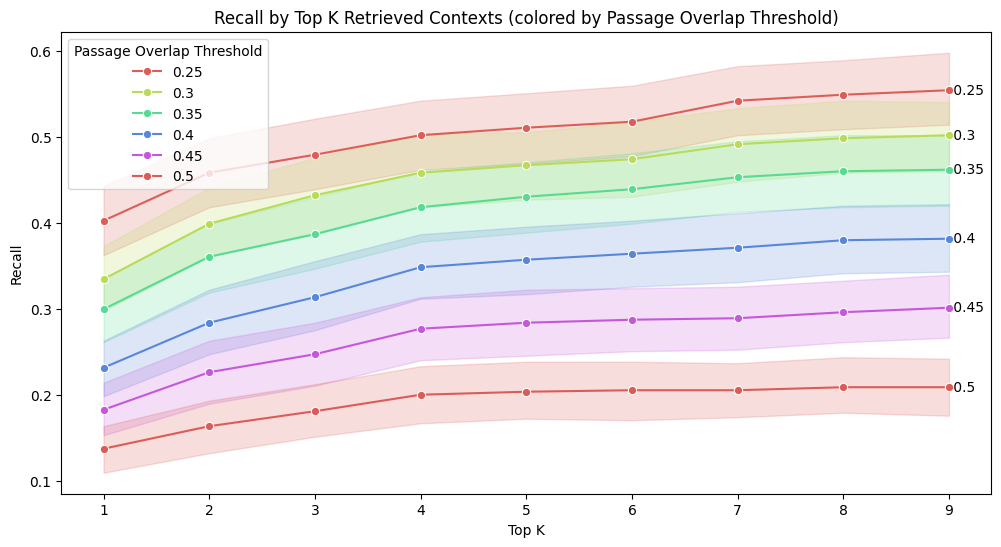

In [46]:
plot_mean_recall_kws(eval_retrieval_kws)

### Semantic Retrieval Evaluation

In [47]:
BERT_SCORE = BertScore(per_instance_score=True)

In [48]:
def compute_recall_semantic(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    
    recall = 0.0

    retrieved_values = retrieved_values[:top_k]
    references = [reference] * len(retrieved_values)
    predictions = retrieved_values.copy()
    result = BERT_SCORE(references=references, predictions=predictions)
    max_score = max(result.extra["bertscore"]["recall"])
    
    return float(max_score >= threshold), max_score

def evaluate_contexts_semantic(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall, score = compute_recall_semantic(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        if debug:
            print(recall, score)
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall,
            score=score,
        ))
    return pd.DataFrame(results)

In [49]:
def batch_eval_semantic_v2(response):
    thresholds = [0.5, 0.65]
    top_k_vals = [1, 5, 10]
    for threshold in thresholds:
        for top_k in top_k_vals:
            logger.debug(f"Evaluating for threshold={threshold}, top_k={top_k}")
            result = evaluate_contexts_semantic_v2(
                response,
                threshold=threshold,
                top_k=top_k, 
                top_k_kws=50,
                debug=False)
            fname = f"data/eval-context-bertscore-{threshold}-{top_k}.csv"
            logger.debug(f"Dumping eval to {fname}")
            result.to_csv(fname, index=False)

def load_context_eval_semantic() -> pd.DataFrame:
    dfs = []
    pattern = "eval-context-bertscore-([0-9.]+)-([0-9]+).csv"
    for path in glob.glob("data/evals/retrieval/bertscore/eval-context-bertscore*.csv"):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

In [50]:
def plot_mean_recall_semantic(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')

    # recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='dark')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

    # recall vs. threshold with lines for each top_k_kws
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')
    plt.title('Recall by Passage Overlap Threshold')
    plt.xlabel('Passage Overlap Threshold')
    plt.ylabel('Recall')
    plt.show()

In [51]:
eval_retrieval_semantic = load_context_eval_semantic()
eval_retrieval_semantic.head()

,context,question,answer,prediction,retrieved_contexts,recall,score,threshold,top_k
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.709230,0.5,10
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.701952,0.5,10
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.706340,0.5,10
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.722527,0.5,10
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.587473,0.5,10


In [52]:
eval_retrieval_semantic.describe()

,recall,score,threshold,top_k
count,3444.000000,3444.000000,3444.000000,3444.000000
mean,0.527294,0.581817,0.575000,5.333333
std,0.499327,0.107731,0.075011,3.682322
min,0.000000,0.357976,0.500000,1.000000
25%,0.000000,0.490861,0.500000,1.000000
50%,1.000000,0.572280,0.575000,5.000000
75%,1.000000,0.675793,0.650000,10.000000
max,1.000000,0.936264,0.650000,10.000000


In [57]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="good")

What type of animal model and age were used to explore the structural and functional consequences of partial weight bearing on bones?


The study used 14-week-old male Wister rats as the animal model to explore the structural and functional consequences of partial weight bearing on bones.


14-week-old male Wister rats were used to investigate structural and functional changes in the skeleton under varying degrees of weight support.


Reduced skeletal loading leads to marked bone loss. Animal models of hindlimb suspension are widely used to assess alterations in skeleton during the course of complete unloading. More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle. Here, we extended these studies to determine the structural and functional skeletal alterations in 14-week-old male Wister rats exposed to 20%, 40%, 70%, or 100% of body weight for 1, 2, or 4 weeks (n equals 11–12/group). Using in vivo pQCT, we found that trabecular bone density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without evidence of a plateau by 4 weeks. Ex vivo measurements of trabecular microarchitecture in the distal femur by microcomputed tomography revealed deficits in bone volume fraction, 2 and 4 weeks after un

More recently, the effects of <b>partial</b> unloading <b>on</b> the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of <b>partial</b> <b>weight</b> <b>bearing</b> (PWB) <b>on</b> the skeleton and skeletal muscle. Here, we extended these studies to determine the <b>structural</b> and <b>functional</b> skeletal alterations in 14-week-old male Wister rats exposed to 20%, 40%, 70%, or 100% of body <b>weight</b> for 1, 2, or 4 weeks (n equals 11-12/group). <b>Using</b> in vivo pQCT, we found that trabecular <b>bone</b> density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without


10.26030/emsm-0648 Related Study : OSD-418  Cite this Study  info Description  Description  Reduced skeletal loading leads to marked <b>bone</b> loss. <b>Animal</b> <b>models</b> of hindlimb suspension are widely <b>used</b> to assess alterations in skeleton during the course of complete unloading. More recently, the effects of <b>partial</b> unloading <b>on</b> the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of <b>partial</b> <b>weight</b> <b>bearing</b> (PWB) <b>on</b> the skeleton and skeletal muscle.


10.26030/b09t-mw60 Related Studies : OSD-418 , OSD-608  Cite this Study  info Description  Description  Reduced skeletal loading leads to marked <b>bone</b> loss. <b>Animal</b> <b>models</b> of hindlimb suspension are widely <b>used</b> to assess alterations in skeleton during the course of complete unloading. More recently, the effects of <b>partial</b> unloading <b>on</b> the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of <b>partial</b> <b>weight</b> <b>bearing</b> (PWB) <b>on</b> the skeleton and skeletal muscle.


Three-point bending of the femoral diaphysis indicated modest or no reductions in femoral stiffness and estimated modulus due to PWB. Our results suggest that this rat <b>model</b> of PWB leads to trabecular <b>bone</b> deterioration that is progressive and generally proportional to the degree of PWB, with minimal effects <b>on</b> cortical <b>bone</b>. This study derives results from the Mechanical Testing, <b>Bone</b> Microstructure (microCT), and <b>bone</b> histomorphometry assays <b>using</b> femur tissue.  Factor(s)  Factor  Ontology: Concept  <b>Partial</b> <b>Weight</b> <b>Bearing</b>  <b>Partial</b> <b>Weight</b>-<b>Bearing</b>  Time  time  Organism(s)  Rattus norvegicus  Assay(s)  Measurement  Technology  Device Platform  <b>Bone</b> biomechanical measurement  <b>Bone</b> biomechanical measurement


Three-point bending of the femoral diaphysis indicated modest or no reductions in femoral stiffness and estimated modulus due to PWB. Our results suggest that this rat <b>model</b> of PWB leads to trabecular <b>bone</b> deterioration that is progressive and generally proportional to the degree of PWB, with minimal effects <b>on</b> cortical <b>bone</b>. This study derives results from the pQCT assay <b>using</b> tibia tissue.  Factor(s)  Factor  Ontology: Concept  <b>Partial</b> <b>Weight</b> <b>Bearing</b>  <b>Partial</b> <b>Weight</b>-<b>Bearing</b>  Time  time  Organism(s)  Rattus norvegicus  Assay(s)  Measurement  Technology  Device Platform  <b>Bone</b> Microstructure  Peripheral Quantitative Computed Tomography  XCT Research SA+(Stratec)  Project  Project Title


gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639403_Rear_Paw_F_C_0PWB_T0  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639406_Rear_Paw_F_C_0PWB_T0  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton


gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639392_Rear_Paw_F_C_0PWB_T14  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639401_Rear_Paw_F_C_0PWB_T14  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton


Objective of this study was to further validate <b>bone</b> degradation in microgravity as site-specific and preferential to <b>weight</b> <b>bearing</b> <b>bone</b>. An objective of this study was to further understand the role of the mechanical environment in controlling the process of <b>bone</b> remodeling, namely local formation and resorption to maintain a healthy structure. These data from the lumbar 4 <b>bones</b> of Rodent Research-1 mission aboard the International Space Station, are unpublished, and were presented at the 2016 meeting of the American Society for Gravitational Space Research. This dataset derives results from the micro-computed tomography (mCT) assay.  Factor(s)


gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639401_Rear_Paw_F_C_0PWB_T07  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton  ~30-60 second  2  Grip Strength  Not Available  LSDS-76_Force Transducer_Grip_Strength_Original_Submitted_Files.zip  ALSDA Transformed Data  LSDS-76_Force Transducer_Bodyweight_Transformed.csv , LSDS-76_Force Transducer_Grip_Strength_Transformed.csv  639403_Rear_Paw_F_C_0PWB_T07  Subject Evironment And Positioning  gently held and restrained by a trained researcher  Experiment Settings  Paw  Bar  50 newton


In [56]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="bad")

Where is the hangar located that houses the F-102 Starfighter?


I don't have information about the location of the hangar that houses the F-102 Starfighter.


The hangar containing F-104 Starfighters is located at Kennedy Space Center.


The increasing availability of flights on suborbital rockets creates new avenues for the study of spaceflight effects on biological systems, in particular the transitions between hypergravity and microgravity. This paper presents an initial comparison of the responses of Arabidopsis thaliana to suborbital and atmospheric parabolic flights as an important step toward characterizing these emerging suborbital platforms and their effects on biology. Transcriptomic profiling of the response of the Arabidopsis ecotype Wassilewskija (WS) to the aggregate spaceflight experiences in the Blue Origin New Shepard and Virgin Galactic SpaceShipTwo rockets revealed that the transcriptomic load induced by flight differed greatly between the two flights, yet was biologically related to traditional parabolic flight responses. The sku5 skewing mutant and 14-3-3κ:GFP regulatory protein overexpression lines each showed altered intra-platform responses compared to WS in the Blue Origin and parabolic flights

In addition, crew members recorded approximately 50 images and over 3 hrs of video of flight operations. Over 2 gigabytes of environmental data were obtained from the flight and ground control units. A ground control experiment was conducted in the BPS ground control chamber in the Orbiter Environment Simulator (OES) at the Kennedy Space Center Launch Site Support Facility in Hangar L. The ground control was delayed by 14-days from the real- time flight operations in order to duplicate the flight operations as closely as possible in a 1 g environment.


Flies were kept in the VFB throughout the 30-day mission and were stored aboard the docked Dragon capsule that shared atmosphere with the ISS. The Dragon capsule unberthed at 13:26 UTC (Co-ordinated Universal Time) on May 18, 2014 and re-entry into the Earth's atmosphere occurred the same day at 19:05 UTC. Following retrieval of the Dragon capsule off the coast of Mexico, the VFB was offloaded at Long Beach Port, California and transported by car to La Jolla, California in a climate-controlled vehicle.


A Ground Control group mimicked the Flight LAR group, which was housed at KSC, then shipped alive, to Novartis' Facilities, where both the LAR and LAR Ground Control groups were processed (~41 weeks old; 1/16/18). All were anesthetized with isoflurane, blood samples were obtained by closed-chest cardiac puncture, and the animals were euthanized by exsanguination and thoracotomy. The 20 ISS Terminal mice were anesthetized via intraperitoneal injection of ketamine/xylazine/acepromazine over the course of a four days of dissections (2/6/18 until 2/9/18; 53-56 days after launch;


A Ground Control group mimicked the Flight LAR group, which was housed at KSC, then shipped alive, to Novartis' facilities, where both the LAR and LAR Ground Control groups were processed (~41 weeks old; 1/16/18). All were anesthetized with isoflurane, blood samples were obtained by closed-chest cardiac puncture, and the animals were euthanized by exsanguination and thoracotomy. The 20 ISS Terminal mice were anesthetized via intraperitoneal injection of ketamine/xylazine/acepromazine over the course of a four days of dissections (2/6/18 until 2/9/18; 53-56 days after launch;


Stainless steel mesh coupon coated with 1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour  Virgin Galactic Unity 22  857 second  sample collection  RNALater  Not Available  SRX20707874  Flight-1-LEAVES-rep2  Arabidopsis thaliana  Col-0  Cotyledons fully open  7 day  F1  Plant Leaves  Internal lab stock maintained by UF Space Plants Laboratory, University of Florida  Suborbital Flight  Growth Protocol  1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour light  Light Emitting Diode Device  continuous light regimen  80 micromole per square meter per second  Treatment Protocol


Ground Control  857 second  sample collection  RNALater  Not Available  SRX20707863  Flight-1-ROOTS-rep1  Arabidopsis thaliana  Col-0  Cotyledons fully open  7 day  F1  Plant Roots  Internal lab stock maintained by UF Space Plants Laboratory, University of Florida  Suborbital Flight  Growth Protocol  1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour light  Light Emitting Diode Device  continuous light regimen  80 micromole per square meter per second  Treatment Protocol  Stainless steel mesh coupon coated with 1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour  Virgin Galactic Unity 22  857 second  sample collection  RNALater  Not Available  SRX20707864


Stainless steel mesh coupon coated with 1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour  Virgin Galactic Unity 22  857 second  sample collection  RNALater  Not Available  SRX20707864  Flight-1-ROOTS-rep2  Arabidopsis thaliana  Col-0  Cotyledons fully open  7 day  F1  Plant Roots  Internal lab stock maintained by UF Space Plants Laboratory, University of Florida  Suborbital Flight  Growth Protocol  1% Phytagel, 0.5× MS media, 5g/L sucrose  24 hour light  Light Emitting Diode Device  continuous light regimen  80 micromole per square meter per second  Treatment Protocol


To this end, a flight group (FLT) of 10-week-old male C57BL/6J mice were launched from Kennedy Space Center (KSC) on 8/14/2017 and housed in Rodent Habitats on the ISS for 33 days before being returned alive to Earth. After splashdown in the Pacific Ocean, the animals were transported to Loma Linda University (LLU) for testing, euthanasia, and dissection on 9/18/2018. Ground Control (GC) studies were planned to commence at KSC approximately one-week after the conclusion of the flight experiments.


Acknowledgments  The authors would like to express their gratitude to Ann Janssen and Ilse Coninx (SCK-CEN) for technical assistance. We are grateful to Dr Proto Pippia and Dr Mariantonia Meloni for providing us access to their ESA RPM facility and Gavino Campus for technical support (University of Sassari, Italy). We thank Dr Mark Ott (Johnson Space Center, Houston, USA) and Ir. Hugo Moors (SCK-CEN) for fruitful discussions.  Contact(s)  Pieter Monsieurs email , Credit: submitter Affiliation: SCK-CEN Email: pmonsieu@sckcen.be Natalie Leys email , Credit: submitter Affiliation: SCK-CEN Email: nleys@sckcen.be Cheryl Nickerson , Credit: Affiliation: Benny Pycke , Credit: Affiliation:


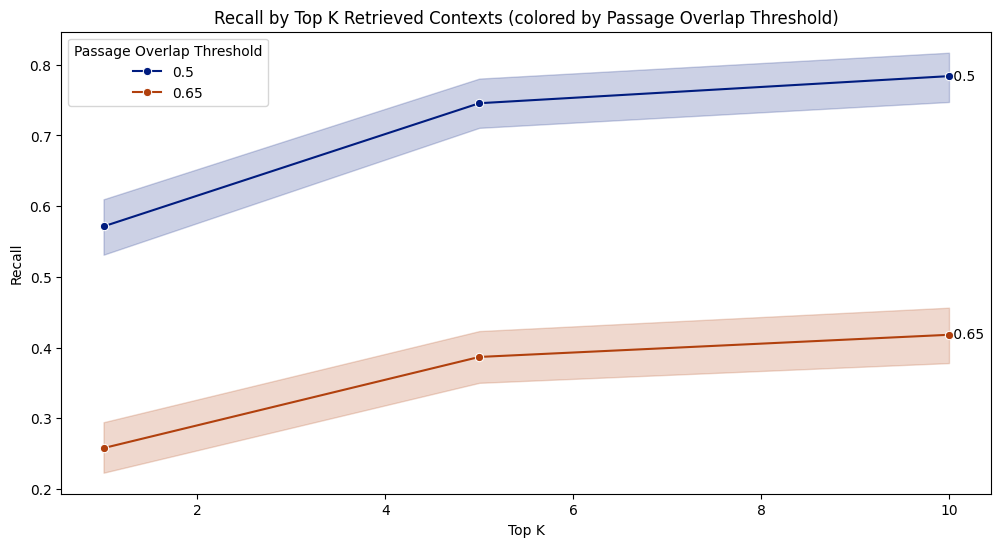

/var/folders/_y/xn9wmmrx1_s68jvjw4gzmxfm0000gn/T/ipykernel_55750/4215088815.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')


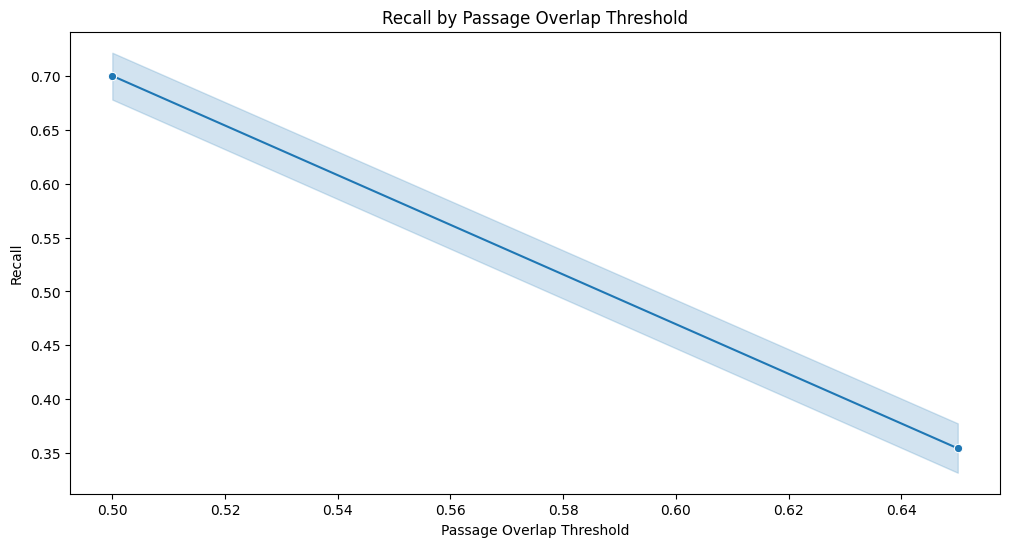

In [55]:
plot_mean_recall_semantic(eval_retrieval_semantic)

## QA Evaluation

Here we focus on semantic evaluation of generated answers which suggest the correctness of the answer w.r.t reference answer.

We use following metrics:


1. **Exacth Match**
2. **METEOR** (Metric for Evaluation of Translation with Explicit Ordering)
    - more aligned with human judgment
    - accounts for exact word matches, *synonyms*, and *paraphrases*
    - useful for evaluating correctness across varied wordings
3. **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation)
   - focuses on recall, measuring *word overlaps* with reference
   - indicates content overlap rather than linguistic quality
   - lower score may suggest fewer exact word matches
4. **BERT Score**
    - *semantic* similarity using contextual embeddings
    - measures how well the generated answers match with references in meaning
    - generalized comparison for a variety of downstream tasks (QA, Translation, Summarization, etc.)

In [58]:
def evaluate_qa(response: pd.DataFrame) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)
    evaluator = Evaluator(metrics=[
        BertScore(),
        ExactMatchMetric(),
        MeteorMetric(),
        RougeMetric(),
    ])
    results = evaluator(
        references=response["reference"].to_list(),
        predictions=response["prediction"].to_list()
    )
    results = pd.DataFrame(results)
    return results

In [59]:
def simplify_response(response: pd.DataFrame) -> pd.DataFrame:
    response = response.copy()
    response["result"] = response["result"].apply(ast.literal_eval)
    res = []
    for row in response.itertuples():
        res.append(dict(
            context=row.reference_context,
            context_hash=row.context_hash,
            question=row.question,
            reference=row.reference_answer,
            ground_truth=row.reference_answer,
            prediction=row.result["answer"],
            retrieved_contexts=row.result["source_documents"]
        ))
    return pd.DataFrame(res)

In [60]:
def plot_eval_result(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.title('Comparison of Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [ ]:
eval_qa = evaluate_qa(
    response=pd.read_csv("data/responses-simplified-gpt-3.5-turbo-rephrased.csv")
)

/Users/npantha/dev/impact/experiments/osdr-bot/venv/lib/python3.10/site-packages/jury/metrics/_core/auto.py:106: UserWarning: Metric exact_match is not available on jury, falling back to evaluate metric. You may not fully utilize this metric for different input types, e.g multiple predictions or multiple references.
  warnings.warn(


In [ ]:
eval_qa

In [ ]:
plot_eval_result(eval_qa)

# Footnotes
- [evalem](https://github.com/NASA-IMPACT/evalem)